In [2]:
from random import choice
import glob

imgs_fps = glob.glob('/home/adelb/Documents/Bpartners/TEST_CODES/test-cotentin/Test_20_Cotentin/*.jpg')

In [44]:
import numpy as np
import onnxruntime as ort
from concurrent.futures import ThreadPoolExecutor, as_completed

# ----------------------------
# Utilities
# ----------------------------
def softmax(x, axis=1, eps=1e-12):
    x = x - np.max(x, axis=axis, keepdims=True)
    ex = np.exp(x)
    return ex / (np.sum(ex, axis=axis, keepdims=True) + eps)

def hann2d(h, w):
    """2D Hann window in [0,1], outer product of 1D Hanns; avoids seams."""
    wy = np.hanning(h)
    wx = np.hanning(w)
    w2d = np.outer(wy, wx)
    # Normalize to max=1 to avoid shrinking confidences
    m = w2d.max() if w2d.size else 1.0
    return (w2d / (m if m > 0 else 1.0)).astype(np.float32)

def sliding_windows(H, W, patch, overlap):
    """Yield top-left (y, x) for a grid that covers the image with given overlap."""
    stride = patch - overlap
    ys = list(range(0, max(H - patch, 0) + 1, stride))
    xs = list(range(0, max(W - patch, 0) + 1, stride))
    # ensure coverage of bottom/right borders
    if ys[-1] != H - patch: ys.append(H - patch)
    if xs[-1] != W - patch: xs.append(W - patch)
    # keep order row-major, with coordinates
    for yi, y in enumerate(ys):
        for xi, x in enumerate(xs):
            yield (len(xs) * yi + xi, y, x)

def pad_to_min(tile, out_h, out_w, pad_val=0):
    """Pad a tile to exactly (out_h,out_w) if needed (shouldn't be needed for 1024)."""
    h, w = tile.shape[-2:]
    if h == out_h and w == out_w:
        return tile
    out = np.full(tile.shape[:-2] + (out_h, out_w), pad_val, dtype=tile.dtype)
    out[..., :h, :w] = tile
    return out

# ----------------------------
# Main predictor
# ----------------------------
class ONNXPatchPredictor:
    def __init__(
        self,
        onnx_path: str,
        num_classes: int,
        input_name: str = None,
        output_name: str = None,
        patch_size: int = 256,
        overlap: int = 64,
        normalize=True,
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
        threads: int = None,  # None => use default; else number of Python worker threads
        providers=None,       # e.g. ["CUDAExecutionProvider", "CPUExecutionProvider"]
    ):
        self.num_classes = int(num_classes)
        self.patch = int(patch_size)
        self.overlap = int(overlap)
        assert 0 <= self.overlap < self.patch, "overlap must be in [0, patch_size)"
        self.normalize = normalize
        self.mean = np.array(mean, dtype=np.float32).reshape(1, 3, 1, 1)
        self.std = np.array(std, dtype=np.float32).reshape(1, 3, 1, 1)
        self.threads = threads

        so = ort.SessionOptions()
        # You can tune these if you like:
        # so.intra_op_num_threads = 1  # leave to ORT if unsure
        # so.inter_op_num_threads = 1
        self.sess = ort.InferenceSession(onnx_path, sess_options=so, providers=providers or ort.get_available_providers())
        self.input_name = input_name or self.sess.get_inputs()[0].name
        self.output_name = output_name or self.sess.get_outputs()[0].name

        # Smooth blending window (Hann). Shape: (1,1,P,P) to broadcast over classes.
        w = hann2d(self.patch, self.patch)
        self.blend_w = w[None, None, ...]  # (1,1,H,W)

    def _prep_batch(self, batch_imgs):
        """batch_imgs: (N, H, W, C_uint8 or float) -> (N,3,H,W) float32 normalized"""
        x = batch_imgs.astype(np.float32) if self.normalize else batch_imgs.astype(np.uint8)
        if self.normalize and x.max() > 1.0:  # assume 0..255
            x = x / 255.0
        # to CHW
        x = np.transpose(x, (0, 3, 1, 2))
        if self.normalize:
            x = (x - self.mean) / self.std
        return x

    def _run(self, xchw):
        """Run one batch through ONNX; returns logits or probs (N,C,H,W)."""
        out = self.sess.run([self.output_name], {self.input_name: xchw})[0]
        # Ensure (N,C,H,W)
        if out.ndim == 3:  # (N,C,H*W)? (rare)
            raise ValueError("Unexpected output shape from model.")
        if out.shape[1] != self.num_classes and out.shape[-1] == self.num_classes:
            # possibly NHWC -> NCHW
            out = np.transpose(out, (0, 3, 1, 2))
        return out.astype(np.float32)

    def predict(self, image: np.ndarray, batch_size: int = 8, assume_logits=True):
        """
        image: (H,W,3) RGB (uint8/float32)
        Returns:
          - mask: (H,W) int32 (argmax of blended probabilities)
          - proba: (C,H,W) float32 blended probabilities (optional for downstream)
        """
        H, W = image.shape[:2]
        P = self.patch
        coords = list(sliding_windows(H, W, P, self.overlap))
        n_tiles = len(coords)

        # extract patches (keep original order index)
        tiles = np.empty((n_tiles, P, P, 3), dtype=image.dtype)
        positions = []
        for idx, y, x in coords:
            tiles[idx] = image[y:y+P, x:x+P, :]
            positions.append((idx, y, x))

        # batched + threaded inference
        # We'll enqueue batches to a thread pool; each task runs 1 batch.
        # NOTE: onnxruntime InferenceSession.run is thread-safe.
        prob_tiles = [None] * n_tiles

        def run_batch(start):
            end = min(start + batch_size, n_tiles)
            x = self._prep_batch(tiles[start:end])
            out = self._run(x)  # (B,C,P,P), logits or probs
            if assume_logits:
                out = softmax(out, axis=1)
            return start, end, out

        # Threading
        if self.threads is None or self.threads <= 1:
            # serial fall-back
            for s in range(0, n_tiles, batch_size):
                start, end, out = run_batch(s)
                for i in range(start, end):
                    prob_tiles[i] = out[i - start]
        else:
            with ThreadPoolExecutor(max_workers=self.threads) as ex:
                futures = [ex.submit(run_batch, s) for s in range(0, n_tiles, batch_size)]
                for f in as_completed(futures):
                    start, end, out = f.result()
                    for i in range(start, end):
                        prob_tiles[i] = out[i - start]

        # blend reconstruction (accumulate weighted probs, then normalize)
        acc = np.zeros((self.num_classes, H, W), dtype=np.float32)
        wsum = np.zeros((1, H, W), dtype=np.float32)

        bw = self.blend_w  # (1,1,P,P)
        for idx, y, x in positions:
            p = prob_tiles[idx][None, ...]  # (1,C,P,P)
            w = bw  # (1,1,P,P)
            acc[:, y:y+P, x:x+P] += (p * w).squeeze(0)
            wsum[:, y:y+P, x:x+P] += w.squeeze(0)

        # Avoid divide-by-zero (shouldn’t happen)
        wsum = np.clip(wsum, 1e-8, None)
        proba = acc / wsum

        # final mask
        mask = np.argmax(proba, axis=0).astype(np.int32)
        return mask, proba
    

class ONNXPatchPredictor2:
    def __init__(
        self,
        onnx_path: str,
        num_classes: int,
        input_name: str = None,
        output_name: str = None,
        patch_size: int = 256,
        overlap: int = 64,
        normalize=True,
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
        providers=None,  # e.g. ["CUDAExecutionProvider", "CPUExecutionProvider"]
    ):
        self.num_classes = int(num_classes)
        self.patch = int(patch_size)
        self.overlap = int(overlap)
        assert 0 <= self.overlap < self.patch, "overlap must be in [0, patch_size)"
        self.normalize = normalize
        self.mean = np.array(mean, dtype=np.float32).reshape(1, 3, 1, 1)
        self.std = np.array(std, dtype=np.float32).reshape(1, 3, 1, 1)

        so = ort.SessionOptions()
        self.sess = ort.InferenceSession(
            onnx_path,
            sess_options=so,
            providers=providers or ort.get_available_providers()
        )
        self.input_name = input_name or self.sess.get_inputs()[0].name
        self.output_name = output_name or self.sess.get_outputs()[0].name

        # Smooth blending window (Hann). Shape: (1,1,P,P) to broadcast over classes.
        w = hann2d(self.patch, self.patch)
        self.blend_w = w[None, None, ...]

    def _prep_batch(self, batch_imgs):
        """Convert (N,H,W,C) uint8/float -> normalized (N,3,H,W) float32"""
        x = batch_imgs.astype(np.float32) if self.normalize else batch_imgs.astype(np.uint8)
        if self.normalize and x.max() > 1.0:
            x = x / 255.0
        x = np.transpose(x, (0, 3, 1, 2))
        if self.normalize:
            x = (x - self.mean) / self.std
        return x

    def _run(self, xchw):
        """Run ONNX inference; returns logits or probs (N,C,H,W)."""
        out = self.sess.run([self.output_name], {self.input_name: xchw})[0]
        if out.ndim == 3:
            raise ValueError("Unexpected output shape from model.")
        if out.shape[1] != self.num_classes and out.shape[-1] == self.num_classes:
            out = np.transpose(out, (0, 3, 1, 2))  # NHWC -> NCHW
        return out.astype(np.float32)

    def predict(self, image: np.ndarray, batch_size: int = 8, assume_logits=True):
        """
        image: (H,W,3) RGB (uint8/float32)
        Returns:
          - mask: (H,W) int32 (argmax of blended probabilities)
          - proba: (C,H,W) float32 blended probabilities
        """
        H, W = image.shape[:2]
        P = self.patch
        coords = list(sliding_windows(H, W, P, self.overlap))
        n_tiles = len(coords)

        # === Extract patches ===
        tiles = np.empty((n_tiles, P, P, 3), dtype=image.dtype)
        positions = []
        for idx, y, x in coords:
            tiles[idx] = image[y:y+P, x:x+P, :]
            positions.append((idx, y, x))

        # === Inference: process ALL patches in batches ===
        prob_tiles = [None] * n_tiles
        for start in range(0, n_tiles, batch_size):
            end = min(start + batch_size, n_tiles)
            batch = self._prep_batch(tiles[start:end])
            out = self._run(batch)  # (B,C,P,P)
            if assume_logits:
                out = softmax(out, axis=1)
            for i in range(start, end):
                prob_tiles[i] = out[i - start]

        # === Blend overlapping predictions ===
        acc = np.zeros((self.num_classes, H, W), dtype=np.float32)
        wsum = np.zeros((1, H, W), dtype=np.float32)
        bw = self.blend_w  # (1,1,P,P)

        for idx, y, x in positions:
            p = prob_tiles[idx][None, ...]  # (1,C,P,P)
            w = bw  # (1,1,P,P)
            acc[:, y:y+P, x:x+P] += (p * w).squeeze(0)
            wsum[:, y:y+P, x:x+P] += w.squeeze(0)

        # Normalize probabilities
        wsum = np.clip(wsum, 1e-8, None)
        proba = acc / wsum

        # Final mask
        mask = np.argmax(proba, axis=0).astype(np.int32)
        return mask, proba


# ----------------------------
# Example usage
# ----------------------------
if __name__ == "__main__":
    # image: HxWx3 RGB uint8, e.g. loaded via OpenCV cv2.cvtColor(cv2.imread(...), cv2.COLOR_BGR2RGB)
    # For your case: H=W=1024, patch=256.
    import cv2

    img = cv2.cvtColor(cv2.imread(choice(imgs_fps)), cv2.COLOR_BGR2RGB)

    predictor = ONNXPatchPredictor(
        onnx_path="/home/adelb/Downloads/comp_200eps_abloss_model3b_3c_se_resnext50_32x4d_512.onnx",
        num_classes=18,                # <-- set your number of classes
        patch_size=512,
        overlap=256,                   # e.g. 64px overlap
        threads=9,                    # parallel model runs
        providers=None,               # or ["CUDAExecutionProvider","CPUExecutionProvider"]
        # input_name="input",         # optionally set if your model uses a custom name
        # output_name="output",       # optionally set if your model uses a custom name
        normalize=False,
    )
    
    predictor2 = ONNXPatchPredictor(
        onnx_path="/home/adelb/Downloads/comp_200eps_abloss_model3b_3c_se_resnext50_32x4d_512.onnx",
        num_classes=18,                # <-- set your number of classes
        patch_size=512,
        overlap=0,                   # e.g. 64px overlap
        threads=9,                    # parallel model runs
        providers=None,               # or ["CUDAExecutionProvider","CPUExecutionProvider"]
        # input_name="input",         # optionally set if your model uses a custom name
        # output_name="output",       # optionally set if your model uses a custom name
        normalize=False,
    )
    
    predictor3 = ONNXPatchPredictor(
        onnx_path="/home/adelb/Downloads/comp_200eps_abloss_model3b_3c_se_resnext50_32x4d_512.onnx",
        num_classes=18,                # <-- set your number of classes
        patch_size=512,
        overlap=256,                   # e.g. 64px overlap
        threads=None,                    # parallel model runs
        providers=None,               # or ["CUDAExecutionProvider","CPUExecutionProvider"]
        # input_name="input",         # optionally set if your model uses a custom name
        # output_name="output",       # optionally set if your model uses a custom name
        normalize=False,
    )
    
    predictor4 = ONNXPatchPredictor(
        onnx_path="/home/adelb/Downloads/comp_200eps_abloss_model3b_3c_se_resnext50_32x4d_512.onnx",
        num_classes=18,                # <-- set your number of classes
        patch_size=512,
        overlap=256,                   # e.g. 64px overlap
        threads=4,                    # parallel model runs
        providers=None,               # or ["CUDAExecutionProvider","CPUExecutionProvider"]
        # input_name="input",         # optionally set if your model uses a custom name
        # output_name="output",       # optionally set if your model uses a custom name
        normalize=False,
    )

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ----------------------------
# Define fixed colors for each class
# ----------------------------
def get_class_colors(num_classes, seed=None):
    """
    Return a random RGB color palette for each class.
    Colors will be different on each run unless a seed is set.
    
    Args:
        num_classes (int): number of classes
        seed (int or None): if set, ensures reproducibility; otherwise random each call.
        
    Returns:
        np.ndarray: shape (num_classes, 3), dtype=uint8, RGB colors.
    """
    rng = np.random.default_rng(seed)
    return rng.integers(low=0, high=256, size=(num_classes, 3), dtype=np.uint8)

# ----------------------------
# Create a colorized mask
# ----------------------------
def colorize_mask(mask, class_colors):
    """
    mask: (H, W) int32, each pixel is a class index.
    class_colors: (num_classes, 3) uint8
    """
    return class_colors[mask]

# ----------------------------
# Plot image + segmentation + legend
# ----------------------------
def plot_segmentation_with_legend(image, mask, class_names=None):
    """
    image: (H, W, 3) uint8
    mask: (H, W) int32 segmentation mask
    class_names: list of str with length = num_classes
    """
    num_classes = mask.max() + 1
    class_colors = get_class_colors(num_classes, seed=42)
    color_mask = colorize_mask(mask, class_colors)

    # Plot original + segmentation
    fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(color_mask)
    ax[1].set_title("Predicted Segmentation")
    ax[1].axis("off")

    # Create legend handles
    handles = []
    for i in range(num_classes):
        color = tuple(class_colors[i] / 255.0)
        label = class_names[i] if class_names and i < len(class_names) else f"Class {i}"
        handles.append(Patch(facecolor=color, edgecolor="black", label=label))

    # Add legend below the plots
    fig.legend(
        handles=handles,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.05),
        ncol=4,
        fontsize=10
    )

    plt.tight_layout()
    plt.show()

    return color_mask

# ----------------------------
# Example usage (integrate with predictor)
# ----------------------------

    


In [5]:
print("""background
cheminee
humidite_clair_autres
humidite_intense_autres
moisissure_clair_tuiles
moisissure_couleur_ardoise
moisissure_couleur_tuiles
moisissure_noircie_tuiles
obstacle
pv
roof_ardoise
roof_autres
roof_tuiles
usure_importante_ardoise
usure_importante_tuiles
usure_legere_ardoise
usure_legere_autres
velux""".splitlines())

['background', 'cheminee', 'humidite_clair_autres', 'humidite_intense_autres', 'moisissure_clair_tuiles', 'moisissure_couleur_ardoise', 'moisissure_couleur_tuiles', 'moisissure_noircie_tuiles', 'obstacle', 'pv', 'roof_ardoise', 'roof_autres', 'roof_tuiles', 'usure_importante_ardoise', 'usure_importante_tuiles', 'usure_legere_ardoise', 'usure_legere_autres', 'velux']


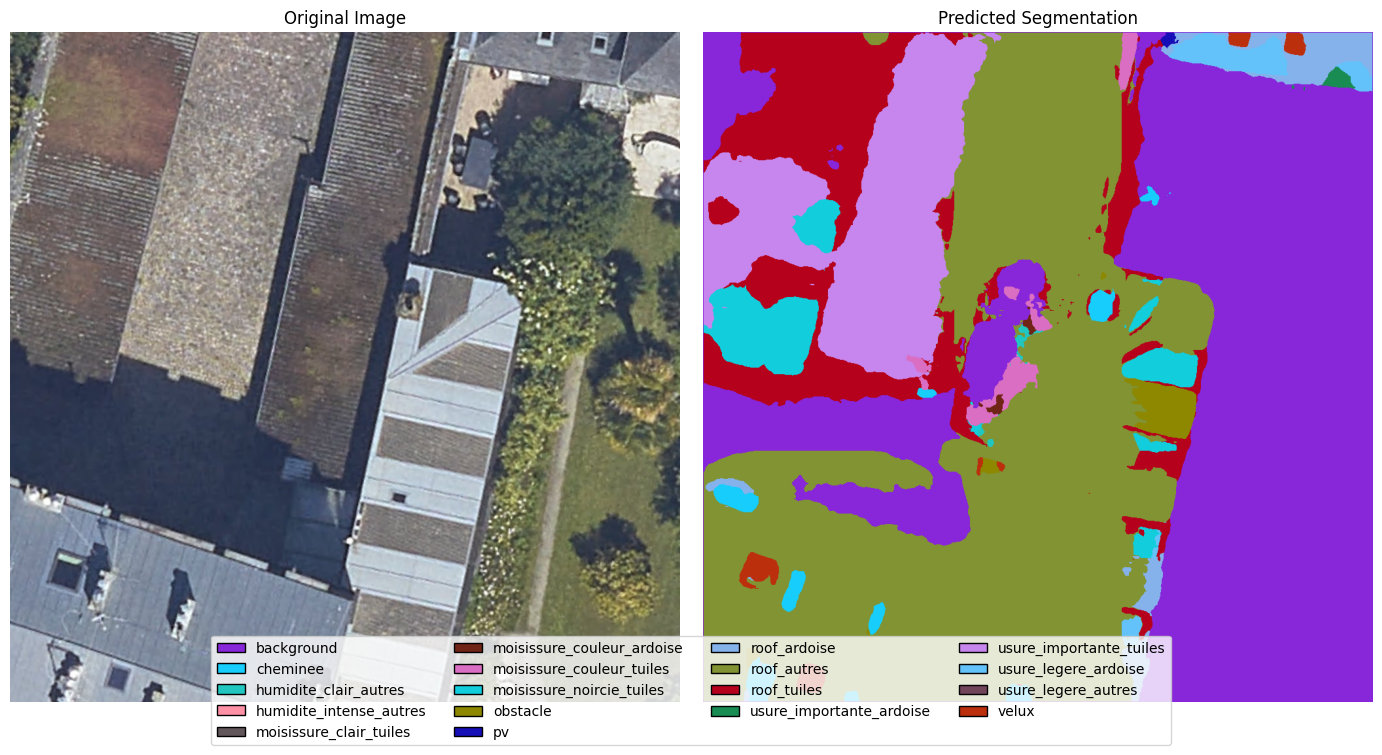

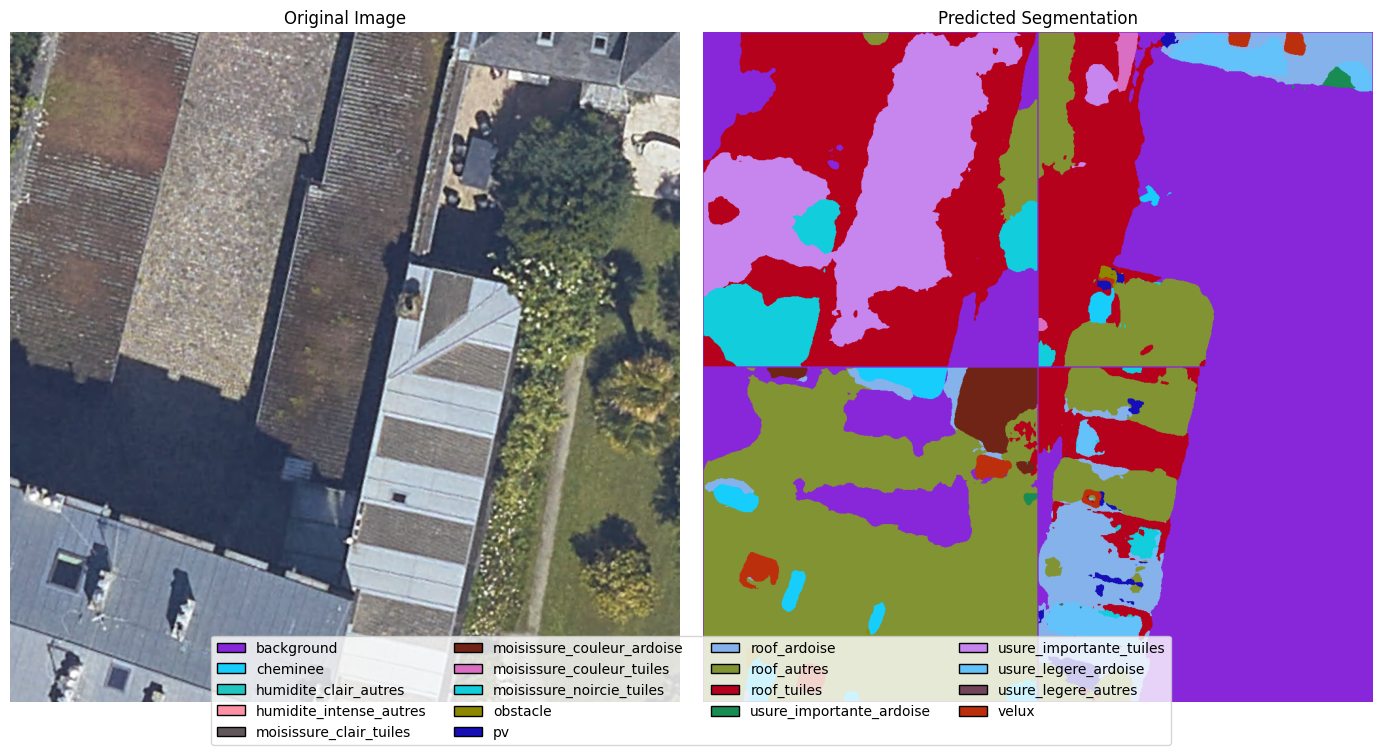

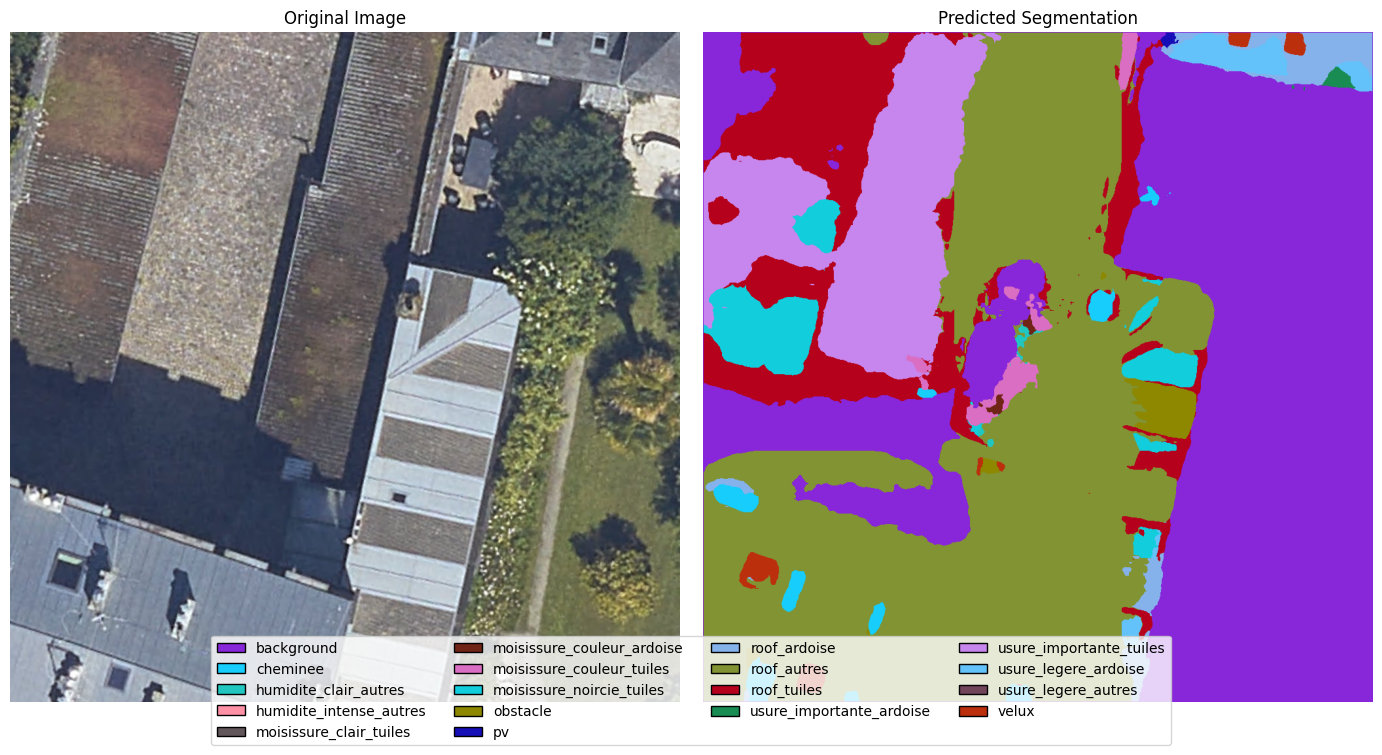

In [47]:
img = cv2.cvtColor(cv2.imread(choice(imgs_fps)), cv2.COLOR_BGR2RGB)

mask, _ = predictor.predict(img, batch_size=9, assume_logits=True)
mask2, _ = predictor2.predict(img, batch_size=9, assume_logits=True)
mask3, _ = predictor3.predict(img, batch_size=9, assume_logits=True)
# Define class names (optional)
class_names = ['Background', 'cheminee', 'humidite_autres', 'moisissure_couleur_ardoise', 'moisissure_tuiles', 'obstacles', 'roof_ardoise', 'roof_autres', 'roof_tuiles', 'usure_ardoise', 'usure_autres', 'usure_tuiles', 'velux']
class_names2 = ['background', 'cheminee', 'humidite_clair_autres', 'humidite_intense_autres', 'moisissure_clair_tuiles', 'moisissure_couleur_ardoise', 'moisissure_couleur_tuiles', 'moisissure_noircie_tuiles', 'obstacle', 'pv', 'roof_ardoise', 'roof_autres', 'roof_tuiles', 'usure_importante_ardoise', 'usure_importante_tuiles', 'usure_legere_ardoise', 'usure_legere_autres', 'velux']


# Plot result + legend
color_mask = plot_segmentation_with_legend(img, mask, class_names=class_names2)
color_mask2 = plot_segmentation_with_legend(img, mask2, class_names=class_names2)
color_mask3 = plot_segmentation_with_legend(img, mask3, class_names=class_names2)


In [ ]:
import timeit

timeit

In [41]:
%%timeit -n 5 -r 5
predictor.predict(img, batch_size=9, assume_logits=True)

4.66 s ± 301 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [46]:
%%timeit -n 5 -r 5
predictor2.predict(img, batch_size=9, assume_logits=True)

2.45 s ± 74.7 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [42]:
%%timeit -n 5 -r 5
predictor3.predict(img, batch_size=9, assume_logits=True)

5.29 s ± 271 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [45]:
%%timeit -n 5 -r 5
predictor4.predict(img, batch_size=9, assume_logits=True)

5.3 s ± 184 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
